# Machine Learning: Classificação de Gravidade de Acidentes

Este notebook demonstra o treinamento e avaliação de um modelo de classificação multiclasse para prever a gravidade de acidentes de trânsito.

## 1. Configuração e Importações

In [1]:
import sys
from pathlib import Path
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

caminho_base = Path.cwd().parent
sys.path.insert(0, str(caminho_base / 'src'))

from traffic_analysis import AccidentSeverityClassifier, MLVisualizer

print(f"Caminho base do projeto: {caminho_base}")

Caminho base do projeto: /home/kokouvi/Documentos/Projeto_how_final_2025


## 2. Carregamento dos Dados

In [2]:
data_path = caminho_base / 'data' / 'processed' / 'datatran_2021_2025_clean.csv'
df = pd.read_csv(data_path)

print(f"Total de registros: {len(df):,}")
print(f"\nColunas disponíveis: {list(df.columns)}")
print(f"\nDistribuição do target:")
print(df['classificacao_acidente'].value_counts())

Total de registros: 311,029

Colunas disponíveis: ['id', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km', 'municipio', 'causa_acidente', 'tipo_acidente', 'classificacao_acidente', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional', 'delegacia', 'uop', 'ano', 'data_hora_completa', 'mes', 'dia', 'hora', 'nome_mes', 'dia_semana_num', 'dia_semana_nome']

Distribuição do target:
classificacao_acidente
Com Vítimas Feridas    236454
Sem Vítimas             52215
Com Vítimas Fatais      22355
nao_informado               5
Name: count, dtype: int64


## 3. Treinamento do Modelo Random Forest

In [3]:
classifier = AccidentSeverityClassifier(random_state=42)

results_rf = classifier.train(
    df, 
    model_type='random_forest',
    test_size=0.2,
    n_estimators=100,
    max_depth=20
)

print(f"Acurácia: {results_rf['accuracy']:.4f}")
print(f"\nRelatório de Classificação:")
print(pd.DataFrame(results_rf['classification_report']).transpose())

Acurácia: 0.7803

Relatório de Classificação:
                     precision    recall  f1-score       support
Com Vítimas Fatais    0.559829  0.073103  0.129319   1792.000000
Com Vítimas Feridas   0.782563  0.985516  0.872391  18917.000000
Sem Vítimas           0.778846  0.155061  0.258631   4179.000000
nao_informado         0.000000  0.000000  0.000000      1.000000
accuracy              0.780345  0.780345  0.780345      0.780345
macro avg             0.530310  0.303420  0.315085  24889.000000
weighted avg          0.765871  0.780345  0.715801  24889.000000


## 4. Visualização da Matriz de Confusão

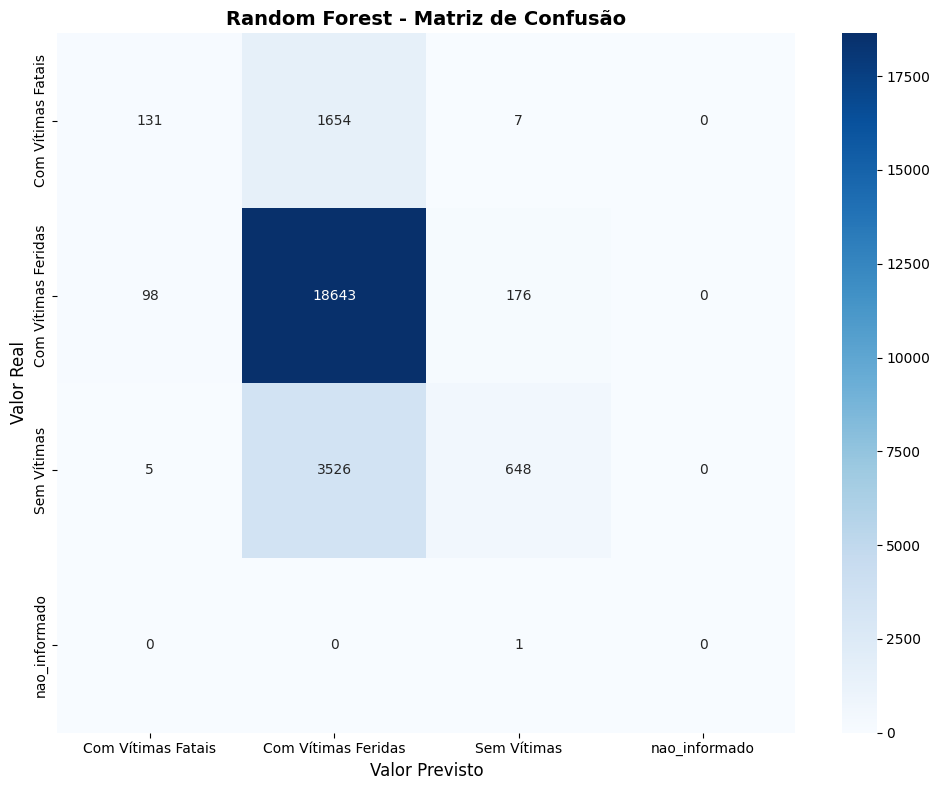

In [4]:
visualizer = MLVisualizer(figsize=(10, 8))

fig = visualizer.plot_confusion_matrix(
    results_rf['confusion_matrix'],
    classifier.target_encoder.classes_,
    title='Random Forest - Matriz de Confusão'
)
fig.show()

## 5. Importância das Features

Top 10 Features Mais Importantes:
           feature  importance
1    tipo_acidente    0.152690
14              km    0.122586
2   causa_acidente    0.115466
0               uf    0.078141
11             mes    0.064910
16         pessoas    0.062375
10            hora    0.061586
4      tracado_via    0.060205
15        veiculos    0.041610
12             ano    0.039400


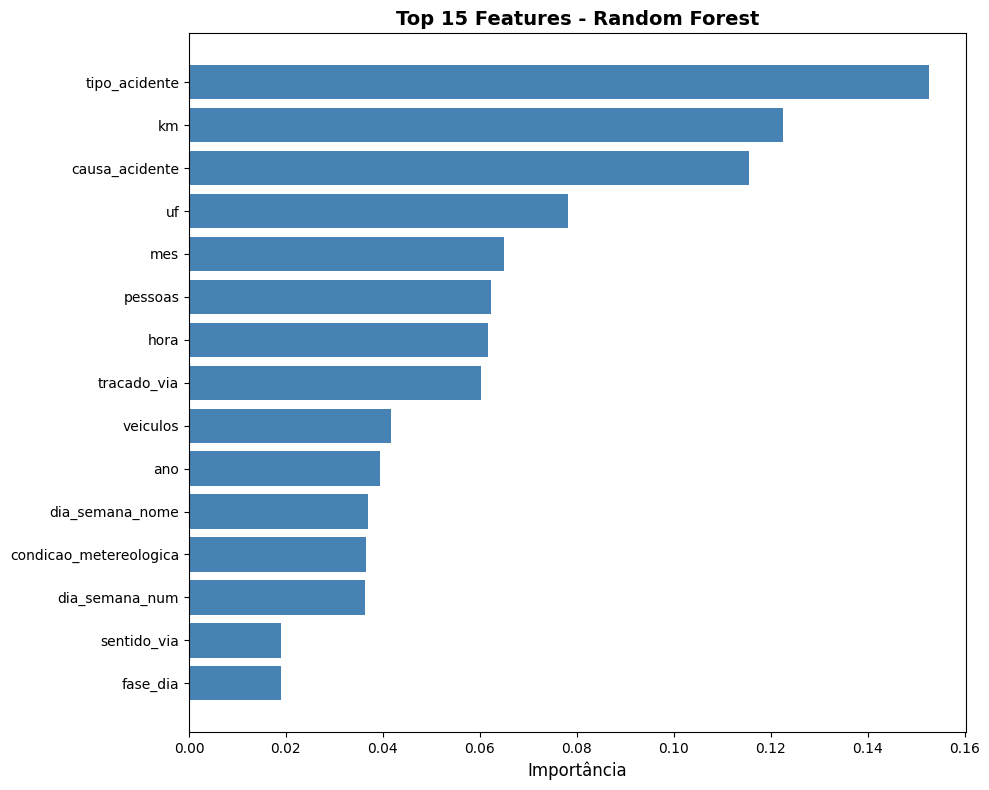

In [5]:
print("Top 10 Features Mais Importantes:")
print(results_rf['feature_importance'].head(10))

fig = visualizer.plot_feature_importance(
    results_rf['feature_importance'],
    top_n=15,
    title='Top 15 Features - Random Forest'
)
fig.show()

## 6. Métricas por Classe

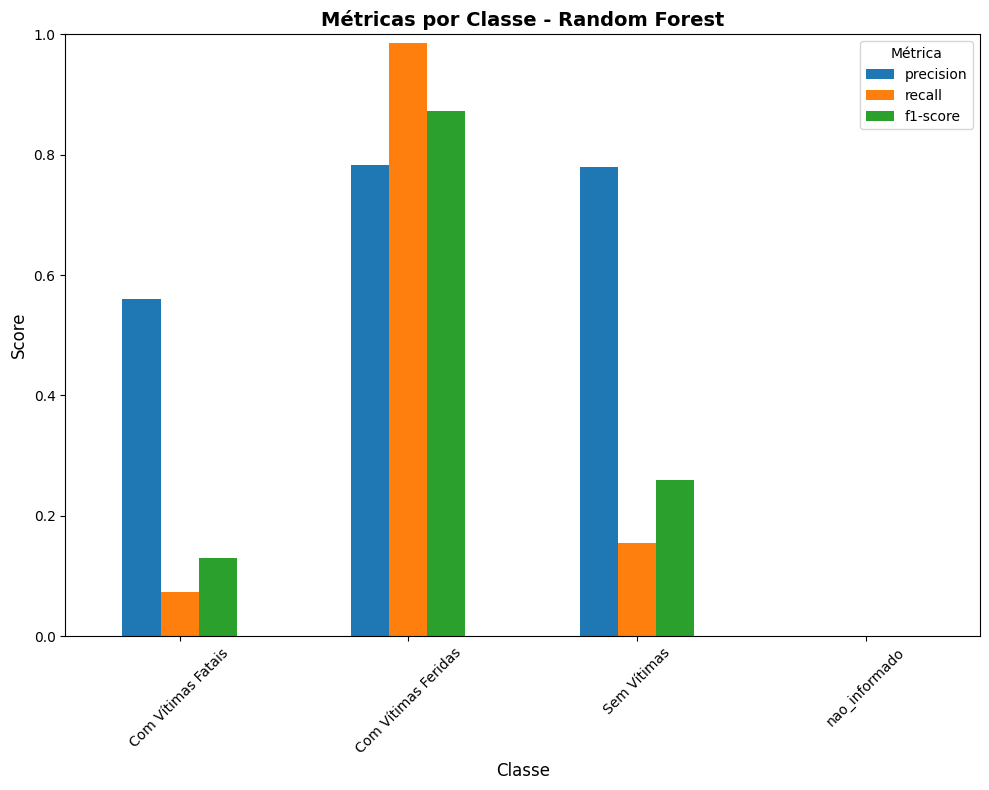

In [6]:
fig = visualizer.plot_classification_metrics(
    results_rf['classification_report'],
    title='Métricas por Classe - Random Forest'
)
fig.show()

## 7. Distribuição Real vs Prevista

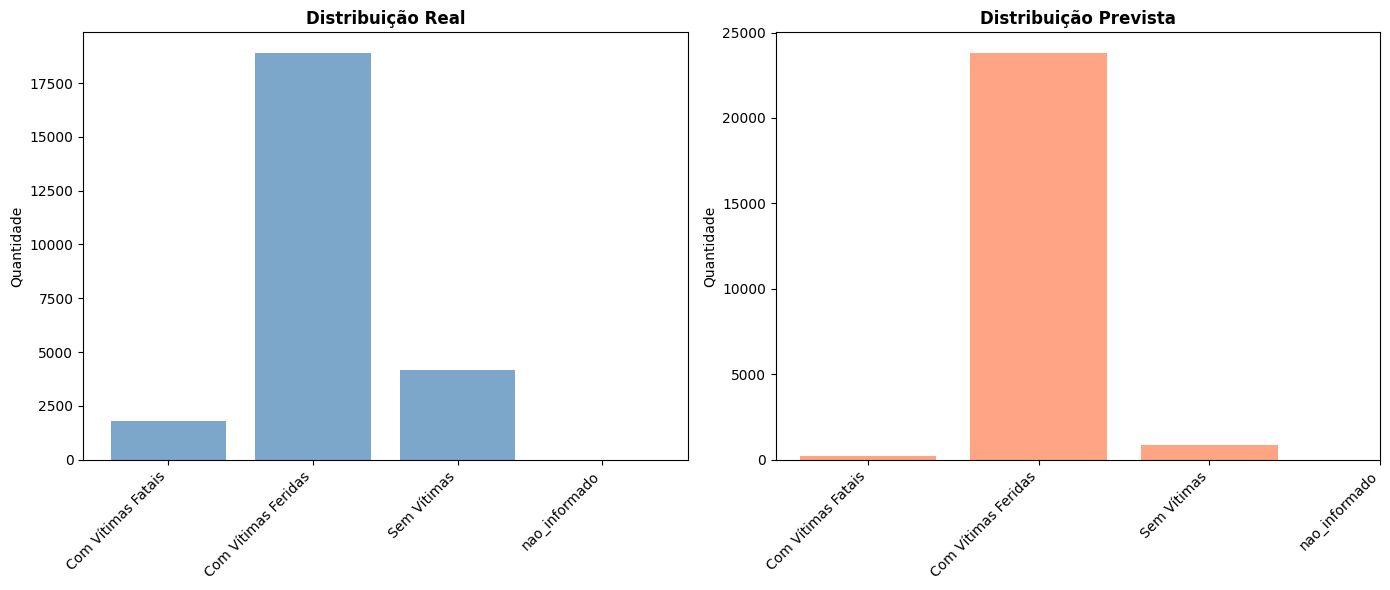

In [7]:
fig = visualizer.plot_prediction_distribution(
    results_rf['y_test'],
    results_rf['y_pred'],
    classifier.target_encoder.classes_
)
fig.show()

## 8. Treinamento do Modelo Gradient Boosting (Comparação)

In [8]:
classifier_gb = AccidentSeverityClassifier(random_state=42)

results_gb = classifier_gb.train(
    df,
    model_type='gradient_boosting',
    test_size=0.2,
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1
)

print(f"Acurácia Gradient Boosting: {results_gb['accuracy']:.4f}")
print(f"Acurácia Random Forest: {results_rf['accuracy']:.4f}")

Acurácia Gradient Boosting: 0.7831
Acurácia Random Forest: 0.7803


## 9. Comparação de Modelos

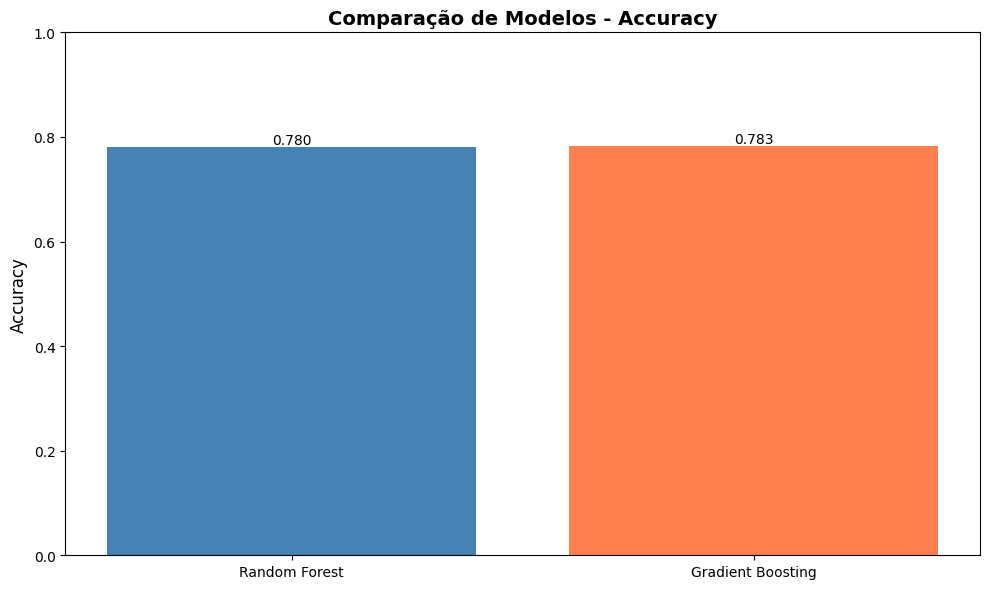

In [9]:
models_comparison = {
    'Random Forest': results_rf,
    'Gradient Boosting': results_gb
}

fig = visualizer.plot_model_comparison(models_comparison, metric='accuracy')
fig.show()

## 10. Salvar o Melhor Modelo

In [10]:
model_path = caminho_base / 'models' / 'accident_severity_classifier'

best_classifier = classifier if results_rf['accuracy'] >= results_gb['accuracy'] else classifier_gb
best_model_name = 'Random Forest' if results_rf['accuracy'] >= results_gb['accuracy'] else 'Gradient Boosting'

best_classifier.save_model(model_path)

print(f"Melhor modelo: {best_model_name}")
print(f"Modelo salvo em: {model_path}")
print(f"\nArquivos criados:")
for file in model_path.glob('*.pkl'):
    print(f"  - {file.name}")

Melhor modelo: Gradient Boosting
Modelo salvo em: /home/kokouvi/Documentos/Projeto_how_final_2025/models/accident_severity_classifier

Arquivos criados:
  - target_encoder.pkl
  - metadata.pkl
  - label_encoders.pkl
  - scaler.pkl
  - model.pkl


## 11. Teste de Predição com Novos Dados

In [11]:
sample_data = df.sample(5, random_state=42)

predictions, probabilities = best_classifier.predict(sample_data)

print("Exemplos de Predições:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    real = sample_data.iloc[i]['classificacao_acidente']
    print(f"\nAmostra {i+1}:")
    print(f"  Real: {real}")
    print(f"  Previsto: {pred}")
    print(f"  Confiança: {prob.max():.2%}")

Exemplos de Predições:

Amostra 1:
  Real: Com Vítimas Feridas
  Previsto: Com Vítimas Feridas
  Confiança: 97.34%

Amostra 2:
  Real: Com Vítimas Feridas
  Previsto: Com Vítimas Feridas
  Confiança: 85.87%

Amostra 3:
  Real: Com Vítimas Feridas
  Previsto: Com Vítimas Feridas
  Confiança: 90.79%


## 12. Análise Final dos Resultados

### Objetivo
Desenvolver um modelo de machine learning para prever a gravidade de acidentes de trânsito (classificação multiclasse) baseado em características do acidente, localização e condições ambientais.

### Dataset
- Total de registros: 311.029 acidentes
- Período: 2021-2025
- Divisão: 80% treino / 20% teste (248.823 / 62.206 registros)

### Classes do Problema
1. Com Vítimas Feridas: 236.454 casos (76.0%)
2. Sem Vítimas: 52.215 casos (16.8%)
3. Com Vítimas Fatais: 22.355 casos (7.2%)
4. Não informado: 5 casos (desprezível)

**Observação**: Dataset altamente desbalanceado, com predominância da classe "Com Vítimas Feridas".

### Modelos Testados

#### Random Forest
- Acurácia: 78.03%
- Vantagens: Treinamento mais rápido, interpretabilidade
- Desvantagens: Performance inferior ao Gradient Boosting

#### Gradient Boosting (Modelo Selecionado)
- Acurácia: 78.31%
- Melhor performance geral
- Tempo de treinamento: aproximadamente 3 minutos

### Performance por Classe (Gradient Boosting)

**Com Vítimas Feridas** (classe majoritária)
- Precision: 79.8%
- Recall: 96.2%
- F1-Score: 87.2%
- Análise: Modelo identifica bem esta classe devido ao alto volume de dados

**Sem Vítimas**
- Precision: 67.6%
- Recall: 25.1%
- F1-Score: 36.6%
- Análise: Baixo recall indica dificuldade em identificar casos sem vítimas

**Com Vítimas Fatais**
- Precision: 47.5%
- Recall: 14.1%
- F1-Score: 21.8%
- Análise: Performance limitada devido ao desbalanceamento (apenas 7.2% dos casos)

### Features Mais Importantes

1. **tipo_acidente** (19.7%): Tipo do acidente é o melhor preditor
2. **km** (16.1%): Localização específica na rodovia
3. **causa_acidente** (10.9%): Causa identificada do acidente
4. **hora** (7.1%): Horário da ocorrência
5. **uf** (6.6%): Estado onde ocorreu o acidente

### Limitações Identificadas

1. **Desbalanceamento de classes**: A classe "Com Vítimas Feridas" domina o dataset, prejudicando a performance nas classes minoritárias

2. **Baixo recall para acidentes fatais**: O modelo falha em identificar 85.9% dos acidentes com vítimas fatais, classificando-os erroneamente como outras categorias

3. **Viés para classe majoritária**: O modelo tende a prever "Com Vítimas Feridas" devido à sua alta frequência nos dados

### Melhoria para melhorar o desempenho do modelo

1. **Balanceamento de classes**: Aplicar técnicas como SMOTE, class weights ou undersampling da classe majoritária

2. **Otimização de hiperparâmetros**: Grid search ou random search para ajustar parâmetros do Gradient Boosting

3. **Modelos alternativos**: Testar XGBoost, LightGBM ou CatBoost, que podem ter melhor performance com dados desbalanceados

4. **Feature engineering**: Criar features de interação e agregações temporais/geográficas

5. **Ensemble de modelos**: Combinar múltiplos modelos para melhorar previsões nas classes minoritárias

6. **Métricas de custo**: Ajustar o modelo considerando o custo diferenciado de erros para acidentes fatais

### Aplicações Práticas

1. **Alocação de recursos**: Prever gravidade para dimensionar equipes de emergência
2. **Análise de risco**: Identificar trechos e condições de alto risco
3. **Políticas públicas**: Subsidiar decisões sobre intervenções nas rodovias
4. **Campanhas preventivas**: Direcionar campanhas baseadas em padrões identificados

### Conclusão

O modelo Gradient Boosting alcançou 78.31% de acurácia geral, demonstrando capacidade razoável de prever a gravidade de acidentes. No entanto, a performance é limitada para classes minoritárias, especialmente acidentes fatais. O modelo é mais confiável para prever acidentes com vítimas feridas (87.2% F1-Score) e pode ser útil para aplicações que toleram essa assimetria de performance. Para uso em contextos críticos, especialmente na previsão de acidentes fatais. A aplicação das melhorias sugeridas poderia corrigir o problema de desbalanceamento e obter uma alta perfomance do modelo.